In [60]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from skimage import color
from tqdm import tqdm, tnrange
import scipy.misc
import skimage
from scipy.misc import imread
from skimage import transform
from skimage import morphology
%matplotlib inline
from keras import backend as K
from tqdm import tnrange
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'resize', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [61]:
counter_params = {
    "morph_thresh" : {
        "BMX":0.5,
        "BX":0.4,
        "KM-5":0.9,
        "SKB":0.4,
        "VIST":0.7,
        "VKT":0.5,
        "MS":0.4,
        "MT50":0.4,
    },
    "small_obj" : {
        "BMX":100,
        "BX":400,
        "KM-5":400,
        "SKB":150,
        "VIST":400,
        "VKT":400,
        "MS":100,
        "MT50":300,
    },
    "square_radius" : {  
        "BMX":5,
        "BX":3,
        "KM-5":15,
        "SKB":20,
        "VIST":3,
        "VKT":10,
        "MS":10,
        "MT50":5,
    },
    "rect_thresh" : {
        "BMX":0.3,
        "BX":0.5,
        "KM-5":0.5,
        "SKB":0.5,
        "VIST":0.6,
        "VKT":0.6,
        "MS":0.5,
        "MT50":0.5,
    },
    "electro_thresh":
    {
        "VKT":[0.0458034682081, 0.41965317919, 0.484255813953, 0.147906976744],
        "KM-5":[0.25, 0.231, 0.1550, 0.2035],
        "TEM":[0.375, 0.18, 0.47, 0.132],
        "VIST":[[0.429, 0.07, 0.287,0.47], [0.429, 0.07, 0.503, 0.27]]
    }
}

In [62]:
electro_types = {"VKT", "KM-5", "TEM", "VIST"}

In [6]:
K.set_image_dim_ordering('th')

In [63]:
counter_type = "BMX"

In [64]:
from keras.models import load_model
model = load_model('datasets/' + counter_type + "_square/"+counter_type + "_square.h5")

IOError: Unable to open file (Unable to open file: name = 'datasets/bmx_square/bmx_square.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [9]:
RESIZED_IMG_SIZE=200.0

In [48]:
from skimage import io
from skimage.color import rgb2gray
def read_img(img_path, img_size=RESIZED_IMG_SIZE):
    img = io.imread(img_path)
    img = transform.resize(img, (min(img.shape[0], img.shape[1]), min(img.shape[0], img.shape[1]), 3))
    resized_gray_img = skimage.transform.resize((io.imread(img_path, as_grey=True)), (int(RESIZED_IMG_SIZE), int(RESIZED_IMG_SIZE))).reshape((1, 1, int(RESIZED_IMG_SIZE), int(RESIZED_IMG_SIZE)))
    #resized_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = transform.resize(img, (img_size, img_size, 3))
    #b, g, r = cv2.split(resized_img)
    #resized_img = cv2.merge([r, g, b])
    return resized_gray_img, resized_img, img

In [11]:
path = glob.glob('datasets/' + counter_type + "_square/test_photos/*")

In [12]:
path

['datasets/SKB_square/test_photos/Od5XNnnfFwU.jpg',
 'datasets/SKB_square/test_photos/xSY2Li8mmL8.jpg',
 'datasets/SKB_square/test_photos/AA.jpg',
 'datasets/SKB_square/test_photos/XYhqRxT2cc0.jpg',
 'datasets/SKB_square/test_photos/S.jpg',
 'datasets/SKB_square/test_photos/wTFJh_r0Iis.jpg',
 'datasets/SKB_square/test_photos/giGBRc9AgdE.jpg',
 'datasets/SKB_square/test_photos/V.jpg']

In [13]:
def predict(model, X, img_size=RESIZED_IMG_SIZE):
    #print(X.shape)
    Y_pred = model.predict(X,verbose=0)
    return Y_pred

In [14]:
from tqdm import tnrange, tqdm_notebook
def find_rect(X):
    max_sum = -float("inf")
    max_point1 = list([0, 0])
    max_point2 = list([1, 1])
    rect_sum = np.zeros(X.shape)
    for i in range(0, rect_sum.shape[0]):
        for j in range(0, rect_sum.shape[1]):
            rect_sum[i][j] += X[i][j]
            if(i):
                rect_sum[i][j] += rect_sum[i - 1][j]
            if(j):
                rect_sum[i][j] += rect_sum[i][j - 1]
            if(i and j):
                rect_sum[i][j] -= rect_sum[i - 1][j - 1]
                
    for left in range(0, X.shape[1], 2):
        for right in range(left + 1, X.shape[1], 2):
            a = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                c = rect_sum[i][right]
                if(i):
                    c -= rect_sum[i - 1][right]
                if(left):
                    c -= rect_sum[i][left - 1]
                if(left and i):
                    c += rect_sum[i - 1][left - 1]
                a[i] = c
            #print(a)
            ans = a[0]
            ans_l = 0
            ans_r = 0
            cur_sum = 0
            minus_pos = -1
    
            for r in range(X.shape[0]):
                cur_sum += a[r];
                if (cur_sum > ans):
                    ans = cur_sum
                    ans_l = minus_pos + 1
                    ans_r = r
 
                if (cur_sum < 0):
                    cur_sum = 0
                    minus_pos = r
                
                
                if(cur_sum > max_sum):
                    #if(counter_type == "BX"):
                        #if(right - left > 2.5 * (ans_r - ans_l)):
                        max_sum = cur_sum
                        max_point1 = [ans_l, left]
                        max_point2 = [ans_r, right]
                
    return max_sum, max_point1, max_point2   

In [53]:
def morphology_img(mask, img, full_img):
    #mask_cp = mask.copy()
    img_cp = img.copy()
    mask = morphology.remove_small_objects(mask,counter_params["small_obj"][counter_type])
    mask = skimage.color.rgb2grey(mask)
    mask = morphology.binary_closing(mask, morphology.square(counter_params["square_radius"][counter_type])) | mask
    ret_mask = mask.copy()
    mask = (morphology.erosion(mask) ^ mask)
    obj = skimage.transform.hough_line(mask)
    
    p = skimage.transform.hough_line_peaks(obj[0], obj[1], obj[2])
    if(len(p) < 2):
        return ret_mask, img, full_img
    p = p[1]
    if(len(p) < 1):
        return ret_mask, img, full_img
    alpha = (p[0]) * 180 / pi
    #print(alpha)
    if(alpha > 0 and alpha <= 90):
        #print(-(90 - alpha))
        return transform.rotate(ret_mask, -(90 - alpha)), transform.rotate(img_cp, -(90 - alpha)), transform.rotate(full_img, -(90 - alpha))
    elif (alpha < 0 and alpha > -90):
        #print(90 + alpha)
        return transform.rotate(ret_mask, 90 + alpha), transform.rotate(img_cp, 90 + alpha), transform.rotate(full_img, 90 + alpha)
    #print(90 + alpha)
    return transform.rotate(ret_mask, 90 + alpha), transform.rotate(img_cp, 90 + alpha), transform.rotate(full_img, 90 + alpha)

In [16]:
def crop_electro_display(display, counter_type):
    width = display.shape[1]
    height = display.shape[0]
    #print(counter_params["electro_thresh"][counter_type][2])
    if(counter_type != "VIST"):
        return display[int(height * counter_params["electro_thresh"][counter_type][2]):int(-height * counter_params["electro_thresh"][counter_type][3]),
                       int(width * counter_params["electro_thresh"][counter_type][0]):int(-width * counter_params["electro_thresh"][counter_type][1])]
    else:
        first_line = display[height * counter_params["electro_thresh"][counter_type][0][2]:-height * counter_params["electro_thresh"][counter_type][0][3],
                       width * counter_params["electro_thresh"][counter_type][0][0]:-width * counter_params["electro_thresh"][counter_type][0][1]]
        second_line = display[height * counter_params["electro_thresh"][counter_type][1][2]:-height * counter_params["electro_thresh"][counter_type][1][3],
                       width * counter_params["electro_thresh"][counter_type][1][0]:-width * counter_params["electro_thresh"][counter_type][1][1]]

In [45]:
def segment(img_path):
    resized_img_gray, resized_img, full_img  = read_img(img_path)
    full_img_cp = resized_img.copy()
    #print(resized_img_gray.shape)
    y = predict(model, resized_img_gray)[0][0]
    #imshow(y)
    #return y, None, None
    #return y, None, None
    mask, img, full_img = morphology_img(y > counter_params["morph_thresh"][counter_type], resized_img, full_img)
    S, point1, point2 = find_rect(mask - counter_params["rect_thresh"][counter_type])
    width_coef = full_img.shape[1] / RESIZED_IMG_SIZE
    height_coef = full_img.shape[0] / RESIZED_IMG_SIZE
    if(counter_type in electro_types):
        display = full_img[int(point1[0] * height_coef):int(point2[0] * height_coef), int(point1[1] * width_coef) :int(point2[1] * width_coef)]
        cropped_img = crop_electro_display(display, counter_type)
        return y, mask, full_img, cropped_img
    else:
        return y, mask, full_img, full_img[int(point1[0] * height_coef):int(point2[0] * height_coef), int(point1[1] * width_coef) :int(point2[1] * width_coef)]

In [18]:
def segment_imgs(imgs_paths):
    no_morphology_masks = list()
    masks = list() 
    imgs = list()
    segmentations = list()
    for path in tqdm(imgs_paths):
        no_morphology_mask, mask, img, segmentation = segment(path)
        no_morphology_masks.append(no_morphology_mask)
        masks.append(mask)
        imgs.append(img)
        segmentations.append(segmentation)
    return no_morphology_masks, masks, imgs, segmentations
        

In [58]:
no_morphology_masks, masks, imgs, segmentations = segment_imgs(list(path))

100%|██████████| 8/8 [00:24<00:00,  3.08s/it]


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


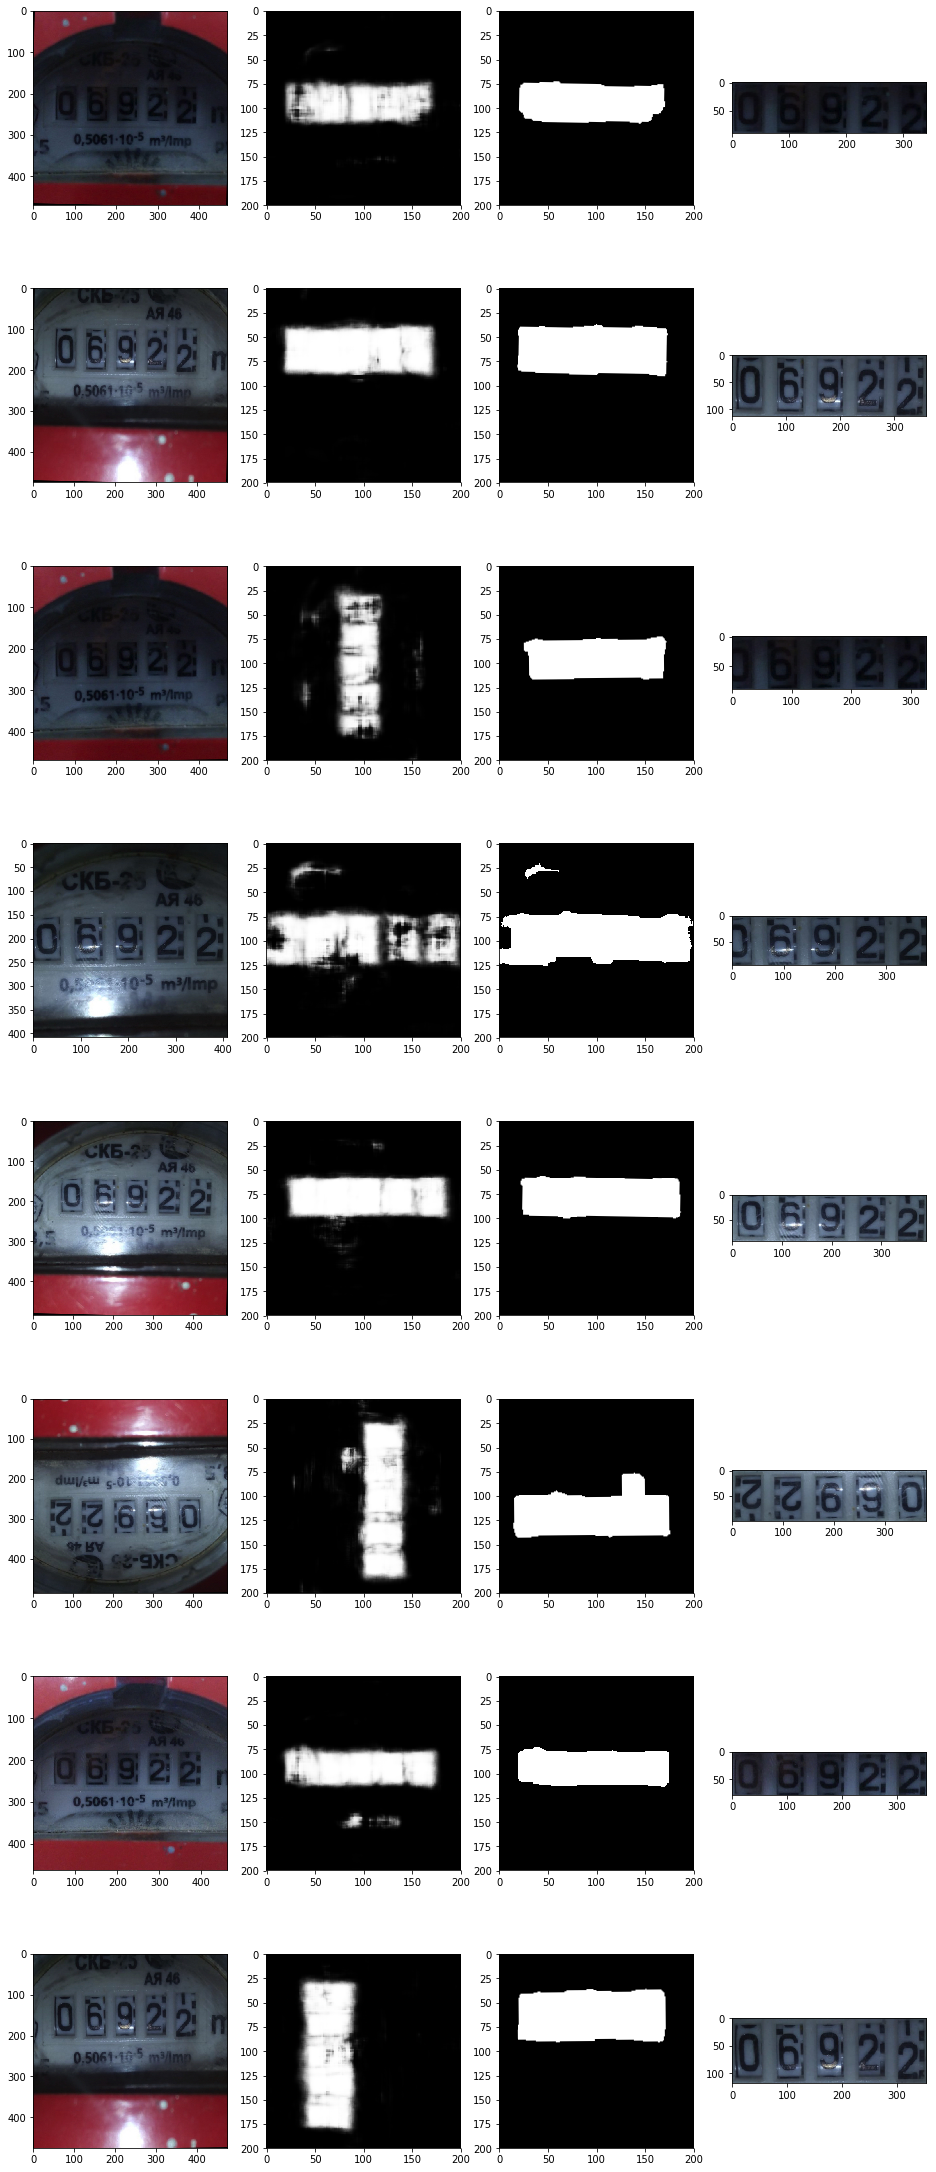

In [59]:
show_num = 8
fig, axes = plt.subplots(nrows=show_num, ncols=4, figsize=(16, 40))
for img_ind in tnrange(show_num):
    axes[img_ind][0].imshow(imgs[img_ind])
    axes[img_ind][1].imshow(no_morphology_masks[img_ind], cmap="gray")
    axes[img_ind][2].imshow(masks[img_ind], cmap="gray")
    axes[img_ind][3].imshow(segmentations[img_ind])

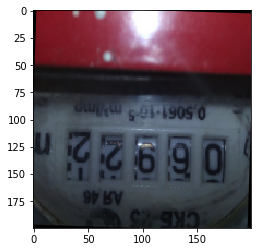

In [41]:
imshow(skimage.transform.rotate(imgs[1], 88))

In [ ]:
imshow(im)

In [183]:
w = img.shape[1]
h = img.shape[0]

In [184]:
left = 50.0 / w
right = 1 - (450.0/w)
top = 95.0 / h
bottom = 1 - (160.0 / h)

In [185]:
print(left)
print(right)
print(top)
print(bottom)

0.0647668393782
0.417098445596
0.494791666667
0.166666666667


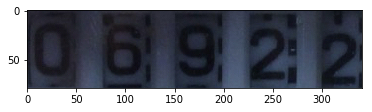

In [49]:
imshow(segmentations[4])

In [50]:
scipy.misc.imsave("datasets/SKB_square/examples/{}.jpg".format(19), segmentations[4])

In [53]:
!mkdir "datasets/MT50_square/examples"

In [136]:
!ls

Untitled.ipynb					 model.png
datasets					 tf_unet_test.ipynb
events.out.tfevents.1488902300.ip-172-31-53-251  train.py
get_graph.ipynb					 unet(production).ipynb
graph.pb					 unet.ipynb


In [85]:
for i in range(20):
    scipy.misc.imsave("datasets/MT50_square/examples/{}.jpg".format(6), segmentations[24])

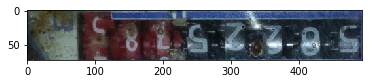

In [90]:
imshow(segmentations[29])